<a href="https://colab.research.google.com/github/neoyipeng2018/cnn/blob/master/CNN_to_stock_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN to stock time series

In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   5884      0 --:--:-- --:--:-- --:--:--  5884
    100% |████████████████████████████████| 5.7MB 6.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62564000 @  0x7fc12f8e92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [4]:
!git clone https://github.com/neoyipeng2018/cnn.git 

Cloning into 'cnn'...
remote: Enumerating objects: 519, done.
remote: Total 519 (delta 0), reused 0 (delta 0), pack-reused 519
Receiving objects: 100% (519/519), 11.26 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [0]:
path = Path('cnn')

In [6]:
df = pd.read_csv(path/'labels.csv')
df.head(2)

,name,label
0,0.png,1
1,1.png,0


In [7]:
path.ls()

[PosixPath('cnn/labels.csv'),
 PosixPath('cnn/input'),
 PosixPath('cnn/cnn_input'),
 PosixPath('cnn/README.md'),
 PosixPath('cnn/.git')]

In [0]:
#path_anno = path/'annotations'
path_img = path/'input'/'img'

In [0]:
data = ImageDataBunch.from_csv(path,csv_labels='labels.csv',folder='input/img',ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

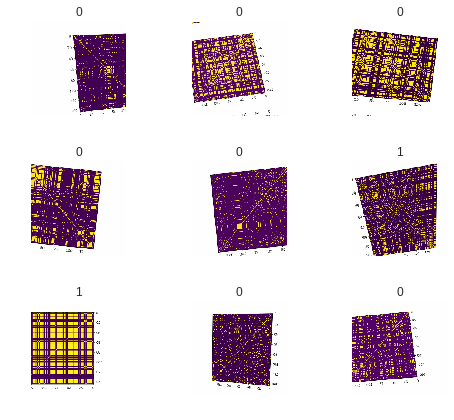

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 18698155.94it/s]


In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.953751,0.527504,0.200000
2,0.879430,0.502805,0.190000
3,0.799019,0.557994,0.260000
4,0.733787,0.641766,0.370000


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

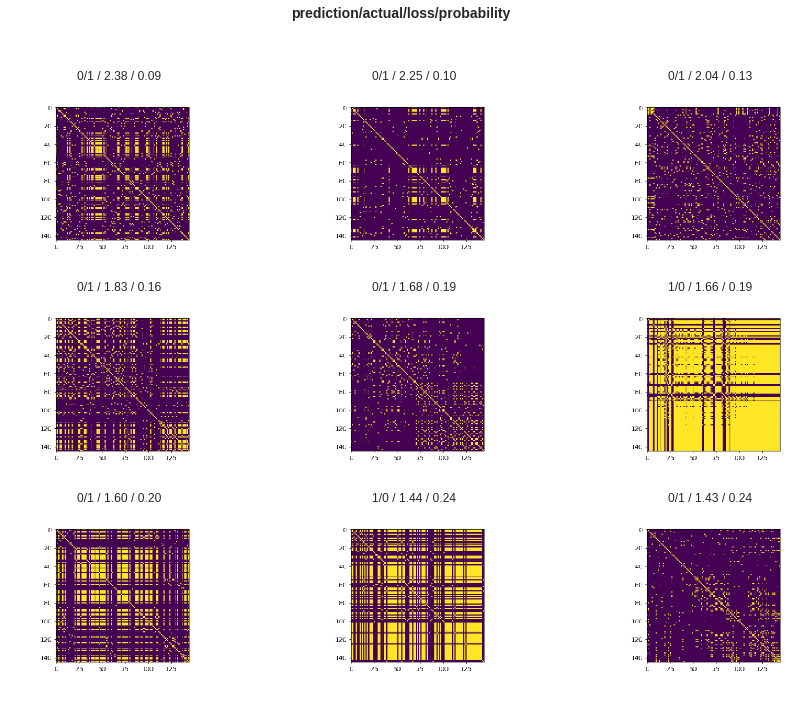

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

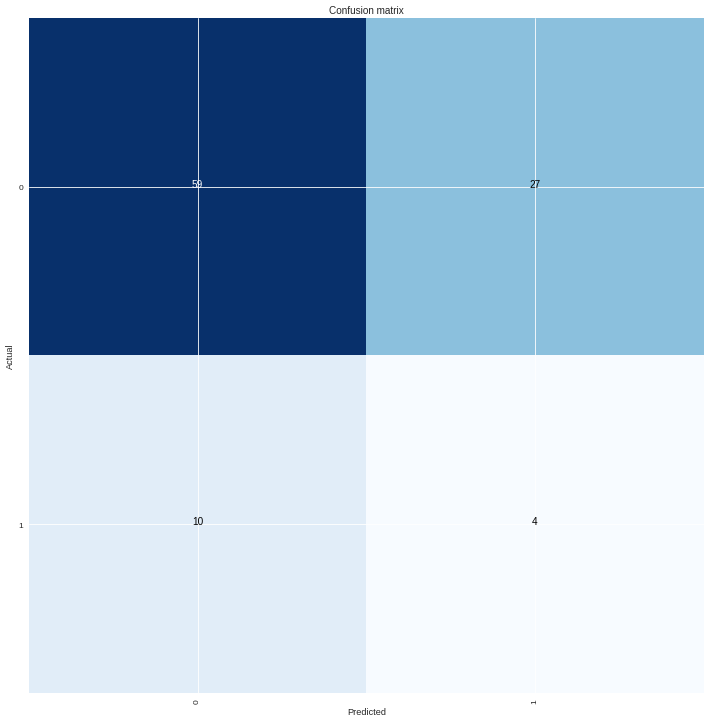

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[(0, 1, 27), (1, 0, 10)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.596628,0.741091,0.460000


In [0]:
learn.load('stage-1');

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


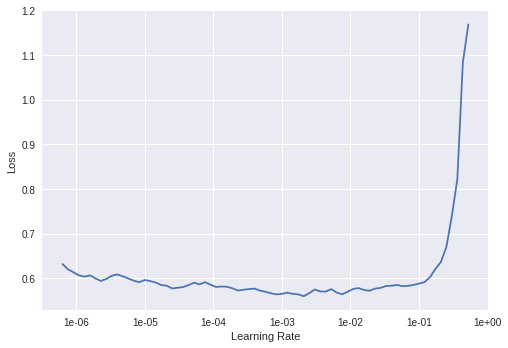

In [26]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.571591,0.481625,0.200000
2,0.593100,0.552134,0.140000
3,0.571100,0.626869,0.160000
4,0.532436,0.580746,0.160000


That's a pretty accurate model!

## Conclusion

So using fastai's CNN pre-set architecture with some fine-tuning of epochs and learning rate, I'm able to achieve around 80% accuracy in predicting next day's move. Now it's time to think of why it wouldn't work.